# Preparation

In [1]:
# GOOGLE_DRV = '/content/drive'
# CHECKPOINT_PATH = GOOGLE_DRV + '/MyDrive/Colab_Notebooks/model'
# TRAIN_DATA_PATH = GOOGLE_DRV + '/MyDrive/Colab_Notebooks/data/train.csv'
# from google.colab import drive
# drive.mount(GOOGLE_DRV)

Mounted at /content/drive


In [9]:
CHECKPOINT_PATH = 'model'
TRAIN_DATA_PATH = 'data/train.csv'

In [6]:
pip show tf-models-official

Name: tf-models-official
Version: 2.11.3
Summary: TensorFlow Official Models
Home-page: https://github.com/tensorflow/models
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /home/kevin/miniconda3/lib/python3.10/site-packages
Requires: Cython, gin-config, google-api-python-client, immutabledict, kaggle, matplotlib, numpy, oauth2client, opencv-python-headless, pandas, Pillow, psutil, py-cpuinfo, pycocotools, pyyaml, sacrebleu, scipy, sentencepiece, seqeval, six, tensorflow, tensorflow-addons, tensorflow-datasets, tensorflow-hub, tensorflow-model-optimization, tensorflow-text, tf-slim
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [2]:
# !mkdir model
# !mkdir data
# !pip install transformers
# !pip install sentencepiece
# !pip install tf-models-official


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 88.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 34.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 66.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━

In [7]:
import os
import pandas as pd
from transformers import T5Tokenizer, TFT5ForConditionalGeneration, T5Config
import tensorflow as tf
import numpy as np
from official.nlp import optimization
import datetime

2023-09-06 19:33:31.502231: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data Import and Preprocess
## Download data files from kaggle
https://www.kaggle.com/c/nlp-getting-started

In [10]:
train_df = pd.read_csv(TRAIN_DATA_PATH)

In [11]:
EXAMPLE_SIZE = train_df.shape[0]

In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [13]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [14]:
train_df.text.tolist()[:5]

['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
 'Forest fire near La Ronge Sask. Canada',
 "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
 '13,000 people receive #wildfires evacuation orders in California ',
 'Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school ']

In [15]:
train_df = train_df.drop(['id', 'keyword', 'location'], axis=1)
train_df = train_df.rename(columns={"text": "input_ids", "target": "labels"})
train_df['labels'] = train_df.labels.map(lambda x : 'positive' if x == 1 else 'negative')
TASK_PREFIX = 'DisasterTweets: '
train_df['input_ids'] = train_df.input_ids.map(lambda x : TASK_PREFIX + x)

In [16]:
train_df.head()

,input_ids,labels
0,DisasterTweets: Our Deeds are the Reason of th...,positive
1,DisasterTweets: Forest fire near La Ronge Sask...,positive
2,DisasterTweets: All residents asked to 'shelte...,positive
3,"DisasterTweets: 13,000 people receive #wildfir...",positive
4,DisasterTweets: Just got sent this photo from ...,positive


In [17]:
train_df[train_df['labels']=='positive']

,input_ids,labels
0,DisasterTweets: Our Deeds are the Reason of th...,positive
1,DisasterTweets: Forest fire near La Ronge Sask...,positive
2,DisasterTweets: All residents asked to 'shelte...,positive
3,"DisasterTweets: 13,000 people receive #wildfir...",positive
4,DisasterTweets: Just got sent this photo from ...,positive
...,...,...
7608,DisasterTweets: Two giant cranes holding a bri...,positive
7609,DisasterTweets: @aria_ahrary @TheTawniest The ...,positive
7610,DisasterTweets: M1.94 [01:04 UTC]?5km S of Vol...,positive
7611,DisasterTweets: Police investigating after an ...,positive


In [12]:
train_df[train_df['labels']=='negative']

,input_ids,labels
15,DisasterTweets: What's up man?,negative
16,DisasterTweets: I love fruits,negative
17,DisasterTweets: Summer is lovely,negative
18,DisasterTweets: My car is so fast,negative
19,DisasterTweets: What a goooooooaaaaaal!!!!!!,negative
...,...,...
7581,DisasterTweets: @engineshed Great atmosphere a...,negative
7582,DisasterTweets: Cramer: Iger's 3 words that wr...,negative
7584,DisasterTweets: These boxes are ready to explo...,negative
7587,DisasterTweets: Sirens everywhere!,negative


<AxesSubplot: >

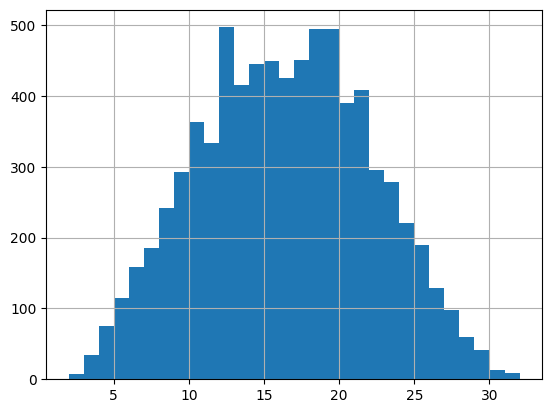

In [18]:
#training tweets length histogram
# max len is 500 (y axis), as twitter limits the tweets to 500 long.
tweet_len = [len(i.split()) for i in train_df.input_ids]
pd.Series(tweet_len).hist(bins = 30)

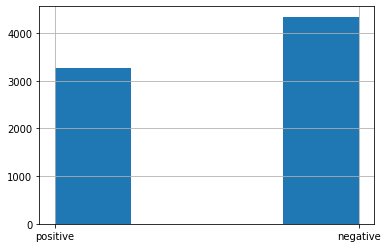

In [14]:
# label class distribution
pd.Series(train_df.labels).hist(bins = 4)

# Prepare tokenizer and tokenize the input

In [19]:
T5_MODEL_VER = 0
t5_model_variants = ("t5-small", "t5-base", "t5-large", "t5-3b", "t5-11b")
t5_tokenizer = T5Tokenizer.from_pretrained(t5_model_variants[T5_MODEL_VER])

In [20]:
in_batch_encoding = t5_tokenizer(train_df['input_ids'].tolist(), padding=True, return_tensors="tf")
targ_batch_encoding = t5_tokenizer(train_df['labels'].astype(str).tolist(),  max_length=2, return_tensors="tf")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [21]:
# spot check tokenizer
te = targ_batch_encoding['input_ids'][22]
t5_tokenizer.decode(te)

'negative</s>'

In [22]:
# construct tf dataset that t5 model can input
ds_train = tf.data.Dataset.from_tensor_slices({'input_ids' : in_batch_encoding.input_ids,
                             'attention_mask' : in_batch_encoding.attention_mask,
                              'labels' : targ_batch_encoding.input_ids,
                              'decoder_attention_mask' : targ_batch_encoding.attention_mask})

In [23]:
# split train/val set
def split_dataset(ds, ds_size, val_split=0.1):
    train_size = int((1 - val_split) * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    
    return train_ds, val_ds
# prefetch, shuffle and batch the dataset
def dataset_prepare(dataset, batch_size=32, training=True):
    dataset = dataset.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(1*1024)
    dataset = dataset.batch(batch_size)
    return dataset

In [24]:
dataset = dataset_prepare(ds_train)
ds_train, ds_val = split_dataset(dataset, EXAMPLE_SIZE)

In [25]:
# peek the dataset
aaa = iter(ds_train)
bbb= next(aaa)
print(bbb)

{'input_ids': <tf.Tensor: shape=(32, 113), dtype=int32, numpy=
array([[29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       ...,
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0],
       [29798,   382,  1123, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(32, 113), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>, 'labels': <tf.Tensor: shape=(32, 2), dtype=int32, numpy=
array([[1465,    1],
       [1465,    1],
       [2841,    1],
       [2841,    1],
       [1465,    1],
       [1465,    1],
       [2841,    1],
       [1465,    1],
       [2841,    1],
       [1465,    1],
       [2841,    1]

In [22]:
# spot check dataset

# print(t5_tokenizer.decode(bbb['input_ids'][3]))
#print(t5_tokenizer.decode(bbb['input_ids'][3], skip_special_tokens=False))
#bbb['attention_mask'][3]
#print(len(bbb['labels'][3]))
# print(t5_tokenizer.decode(bbb['labels'][3], skip_special_tokens=False))
#bbb['labels'][3]

# Prepare model


TensorFlow models and layers in transformers accept two formats as input:

having all inputs as keyword arguments (like PyTorch models), or
having all inputs as a list, tuple or dict in the first positional argument.
The reason the second format is supported is that Keras methods prefer this format when passing inputs to models and layers. Because of this support, when using methods like model.fit() things should “just work” for you - just pass your inputs and labels in any format that model.fit() supports! If, however, you want to use the second format outside of Keras methods like fit() and predict(), such as when creating your own layers or models with the Keras Functional API, there are three possibilities you can use to gather all the input Tensors in the first positional argument:

a single Tensor with input_ids only and nothing else: model(input_ids)
a list of varying length with one or several input Tensors IN THE ORDER given in the docstring: model([input_ids, attention_mask]) or model([input_ids, attention_mask, token_type_ids])
a dictionary with one or several input Tensors associated to the input names given in the docstring: model({"input_ids": input_ids, "token_type_ids": token_type_ids})
Note that when creating models and layers with subclassing then you don’t need to worry about any of this, as you can just pass inputs like you would to any other Python function!

In [26]:
# from_pretrained method will download and cache the model
# TFT5ForConditionalGeneration is a huggingface T5 Model with a language modeling head on top.
# CLM (causal language model, autoregresive means the same thing)
t5_model = TFT5ForConditionalGeneration.from_pretrained(t5_model_variants[T5_MODEL_VER])

All model checkpoint layers were used when initializing TFT5ForConditionalGeneration.

All the layers of TFT5ForConditionalGeneration were initialized from the model checkpoint at t5-small.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFT5ForConditionalGeneration for predictions without further training.


In [27]:


# epochs = 20
epochs = 20
batch_size = 32
init_lr = 1e-4

steps_per_epoch = 1406
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = num_train_steps // 10


optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw')
#optimizer = tf.keras.optimizers.Adam(init_lr)

#metrics = [tf.keras.metrics.SparseTopKCategoricalAccuracy(name='accuracy')]

t5_model.compile(optimizer=optimizer, loss='passthrough')


t5_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PATH,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

log_dir = 'tensorboard'
start_profile_batch = steps_per_epoch + 10
stop_profile_batch = start_profile_batch + 100
#profile_range = f"{start_profile_batch},{stop_profile_batch}"
log_path = log_dir + "/t5/" + datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
t5_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_path, histogram_freq=1,
                                                #profile_batch=profile_range,
                                                update_freq=20)

t5_earlystop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
callbacks = [t5_checkpoint, t5_tensorboard, t5_earlystop]

No loss specified in compile() - the model's internal loss computation will be used as the loss. Don't panic - this is a common way to train TensorFlow models in Transformers! To disable this behaviour please pass a loss argument, or explicitly pass `loss=None` if you do not want your model to compute a loss.


# Training

In [29]:
history = t5_model.fit(
            x=ds_train,
            validation_data=ds_val,
            callbacks=callbacks,
            epochs=epochs)


Epoch 1/20
Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


238/238 [==============================] - ETA: 0s - loss: 8.1038

2023-09-06 19:42:29.347134: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-09-06 19:42:31.442728: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-09-06 19:42:33.691057: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.


238/238 [==============================] - 61s 194ms/step - loss: 8.1038
Epoch 2/20
238/238 [==============================] - ETA: 0s - loss: 1.0458

2023-09-06 19:43:18.233842: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.
2023-09-06 19:43:19.277892: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 3947888640 exceeds 10% of free system memory.


238/238 [==============================] - 48s 200ms/step - loss: 1.0458
Epoch 3/20
238/238 [==============================] - 48s 200ms/step - loss: 0.3007
Epoch 4/20
238/238 [==============================] - 47s 199ms/step - loss: 0.2571
Epoch 5/20
238/238 [==============================] - 48s 200ms/step - loss: 0.2351
Epoch 6/20
238/238 [==============================] - 48s 201ms/step - loss: 0.2217
Epoch 7/20
238/238 [==============================] - 49s 205ms/step - loss: 0.2064
Epoch 8/20
238/238 [==============================] - 47s 199ms/step - loss: 0.1986
Epoch 9/20
238/238 [==============================] - 47s 199ms/step - loss: 0.1864
Epoch 10/20
238/238 [==============================] - 50s 211ms/step - loss: 0.1798
Epoch 11/20
238/238 [==============================] - 50s 212ms/step - loss: 0.1709
Epoch 12/20
238/238 [==============================] - 51s 216ms/step - loss: 0.1608
Epoch 13/20
238/238 [==============================] - 48s 201ms/step - loss: 0.1475

In [28]:
t5_model.summary()

Model: "tft5_for_conditional_generation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 shared (Embedding)          multiple                  16449536  
                                                                 
 encoder (TFT5MainLayer)     multiple                  35330816  
                                                                 
 decoder (TFT5MainLayer)     multiple                  41625344  
                                                                 
Total params: 60,506,624
Trainable params: 60,506,624
Non-trainable params: 0
_________________________________________________________________


In [30]:
inputs = t5_tokenizer("DisasterTweets: I went to see a doctor.", return_tensors="tf").input_ids 
inputs = t5_tokenizer("summarize: I was hiking toward his isolated valley in the Hengduan Mountains when Yang drove up the steep trail on his motorcycle to greet me. I had arranged to stay at his family’s rustic guesthouse, which was a clutch of log cabins tucked among fallow fields of potatoes and wheat. Yang indeed looked manly in his brown leather coat and blue jeans. But if he seemed like any other typically rakish mountaineer in this rugged part of China, my introduction to his household told me differently. His home was occupied exclusively by women relatives. And Yang wasn’t only outnumbered. He was out-talked.", return_tensors="tf").input_ids 
inputs = t5_tokenizer("cola: I would have been killing you", return_tensors="tf").input_ids 
inputs = t5_tokenizer("sst2: i do enjoy wonderful", return_tensors="tf").input_ids
outputs = t5_model.generate(inputs)
print(t5_tokenizer.decode(outputs[0], skip_special_tokens=True))

/home/kevin/miniconda3/lib/python3.10/site-packages/transformers/generation/tf_utils.py:702: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


positive


In [31]:
t5_model.save(CHECKPOINT_PATH)

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [29]:
checkpoint = tf.train.Checkpoint(t5_model)
save_path = checkpoint.save(CHECKPOINT_PATH)